In [1]:
from interaction_inference import simulation, dataset
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import tqdm
import numpy as np

In [2]:
rng = np.random.default_rng()

# Stationary distribution: effect of interaction & gene switch

An independent birth-death model has a Poisson stationary distribution that is easy to visualize, but what happens the the distribution when interaction is added to the model? or when a gene switch is added to give a telegraph model?

We plot stationary distributions for a range of $k_{reg}$ (interaction) and $k_{on}$ (gene switch) values to visualize the changes that occur:

In [71]:
interaction_values = [0, 1, 5, 10]
gene_values = [1.0, 0.9, 0.5, 0.1]

# number of pairs
gene_pairs = len(interaction_values) * len(gene_values)
cells = 1000
rate = 5
gene = 1

# dataframes
params_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=['k_on_1', 'k_on_2', 'k_off_1', 'k_off_2', 'k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg'])
counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=[f"Cell-{j}" for j in range(cells)])

# for each gene
k = 0
for intr in interaction_values:
    for gene in gene_values:

        # Set reaction rate parameters
        k_on_1 = gene
        k_on_2 = gene
        k_off_1 = 1 - gene
        k_off_2 = 1 - gene
        k_tx_1 = rate
        k_tx_2 = rate
        k_deg_1 = 1
        k_deg_2 = 1
        k_reg = intr

        # store parameters
        params_df.iloc[k] = [k_on_1, k_on_2, k_off_1, k_off_2, k_tx_1, k_tx_2, k_deg_1, k_deg_2, k_reg]

        params = {
            'k_on_1': k_on_1,
            'k_on_2': k_on_2,
            'k_off_1': k_off_1,
            'k_off_2': k_off_2,
            'k_tx_1': k_tx_1,
            'k_tx_2': k_tx_2,
            'k_deg_1': k_deg_1,
            'k_deg_2': k_deg_2,
            'k_reg': k_reg
        }

        # simulate sample from model
        sample = simulation.gillespie_telegraph(params, cells)

        # store counts
        counts_df.iloc[k] = sample

        # next gene pair
        k += 1

# construct dataset object
data = dataset.Dataset("Test")

# store information
data.count_dataset = counts_df
data.param_dataset = params_df
data.cells = cells
data.gene_pairs = gene_pairs
data.beta = np.array([1.0 for j in range(cells)])

In [72]:
data.bootstrap_marginal_probabilities()

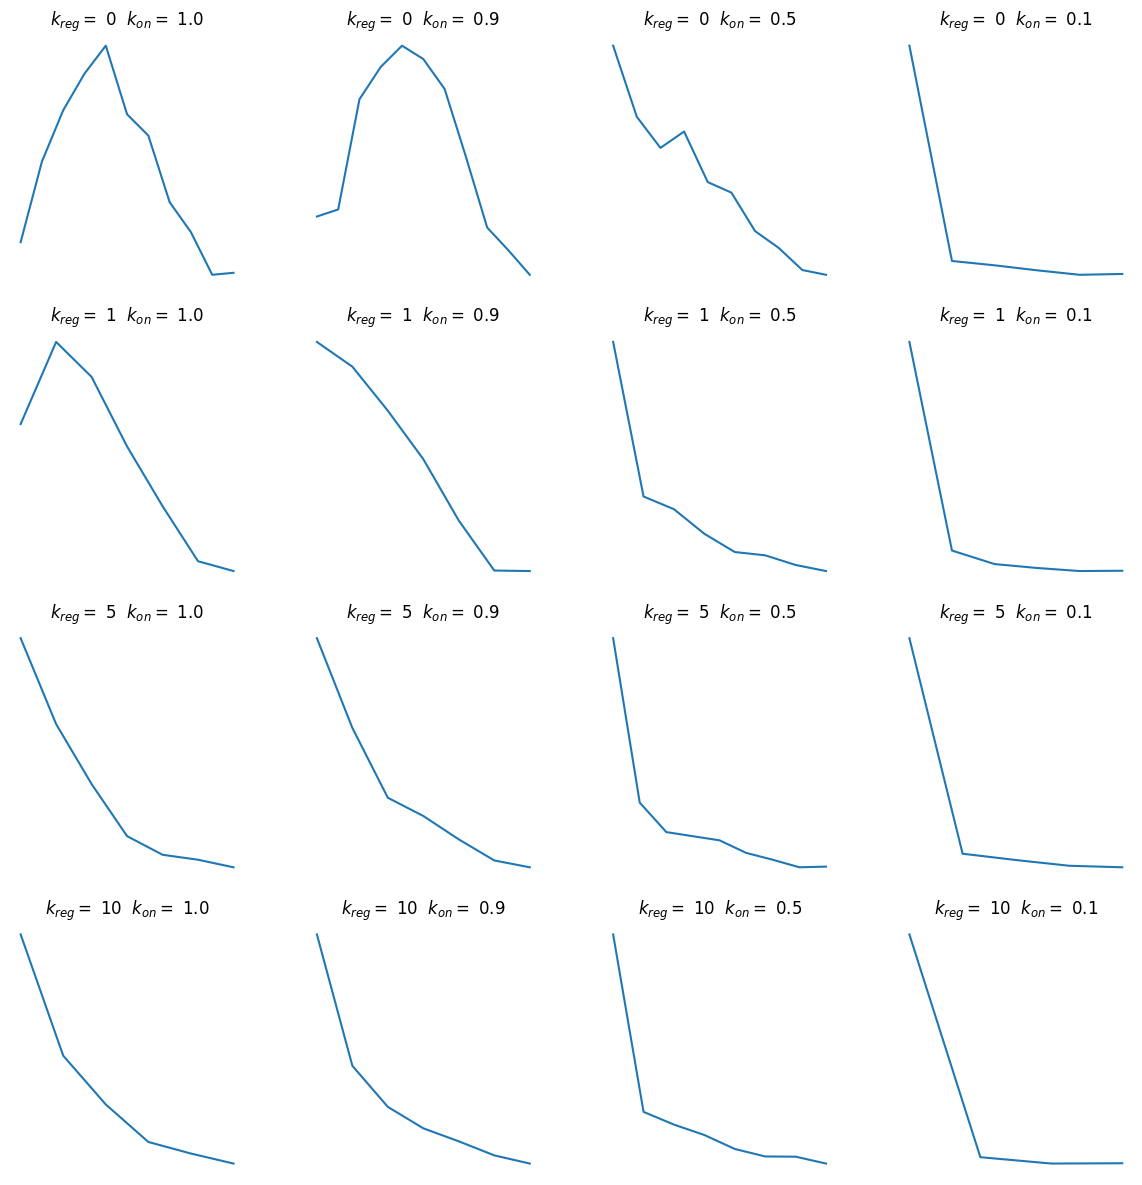

In [73]:
fig, axs = plt.subplots(len(interaction_values), len(gene_values), figsize=(12, 12))
plt.tight_layout()

k = 0
for i, intr in enumerate(interaction_values):
    for j, gene in enumerate(gene_values):

        bounds = data.probs_OB[f'sample-{k}']['x1_bounds']
        N = bounds.shape[1]
        dist = np.empty(N)
        for n in range(N):
            if bounds[0, n] == 0 and bounds[1, n] == 1:
                dist[n] = None
            else:
                dist[n] = (bounds[0, n] + bounds[1, n]) / 2

        axs[i, j].plot(dist)
        axs[i, j].set_title(r"$k_{reg} =$" + f" {intr} " + r" $k_{on} =$" + f" {gene}")
        axs[i, j].axis('off')

        k += 1

A grid of distributions with increasing $k_{reg}$ down the rows, and decreasing $k_{on}$ along the columns

## Capture efficiency

In [75]:
beta = rng.beta(1, 2, size=1000)
data_downsampled = data.downsample("Test", beta)
data_downsampled.bootstrap_marginal_probabilities()

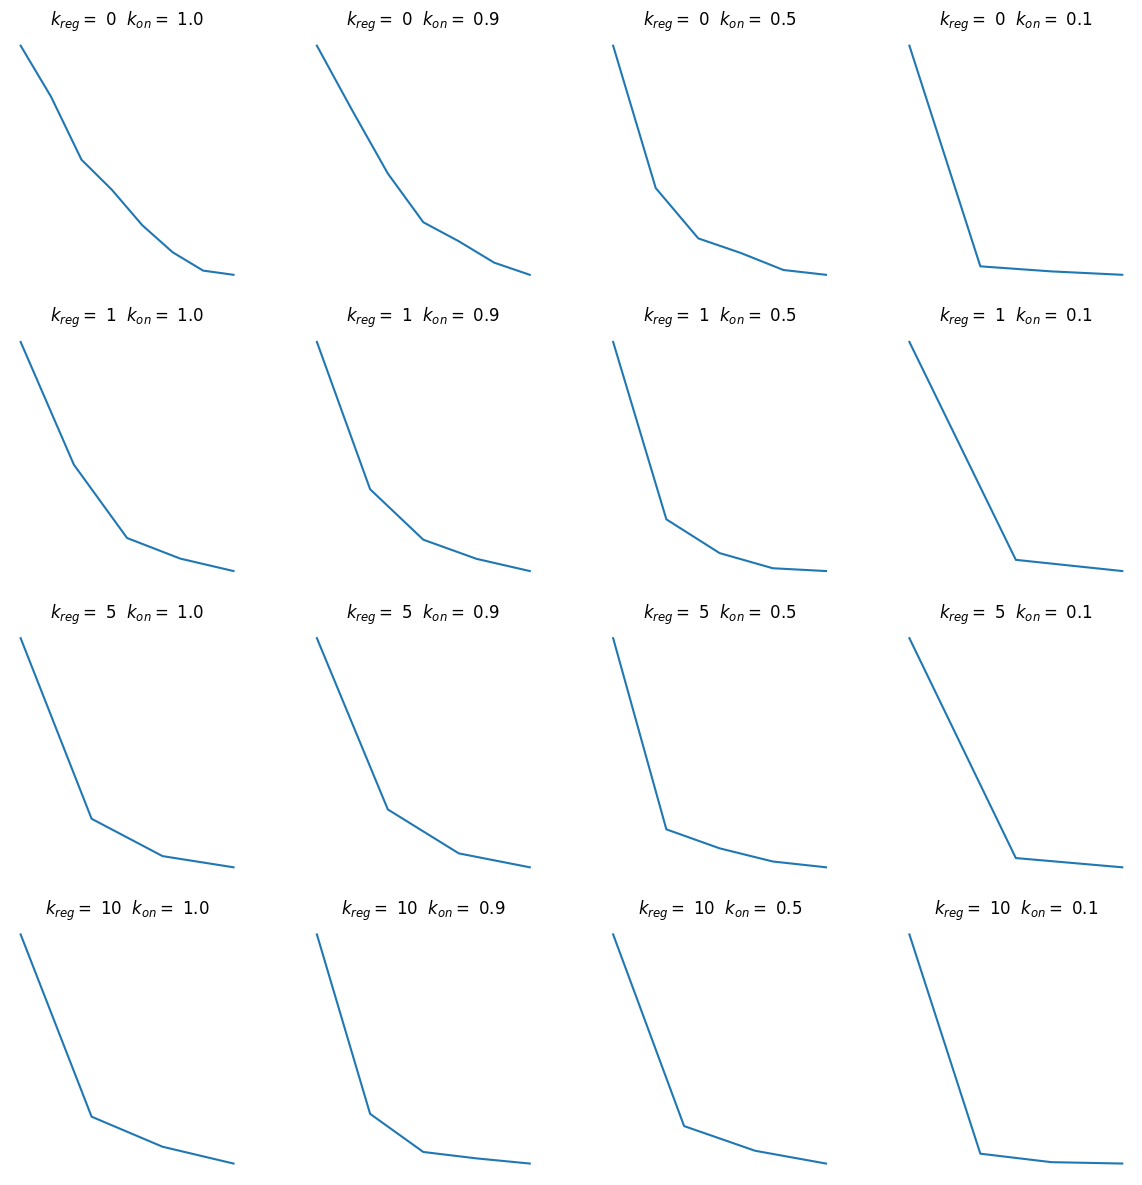

In [76]:
fig, axs = plt.subplots(len(interaction_values), len(gene_values), figsize=(12, 12))
plt.tight_layout()

k = 0
for i, intr in enumerate(interaction_values):
    for j, gene in enumerate(gene_values):

        bounds = data_downsampled.probs_OB[f'sample-{k}']['x1_bounds']
        N = bounds.shape[1]
        dist = np.empty(N)
        for n in range(N):
            if bounds[0, n] == 0 and bounds[1, n] == 1:
                dist[n] = None
            else:
                dist[n] = (bounds[0, n] + bounds[1, n]) / 2

        axs[i, j].plot(dist)
        axs[i, j].set_title(r"$k_{reg} =$" + f" {intr} " + r" $k_{on} =$" + f" {gene}")
        axs[i, j].axis('off')

        k += 1

Repeat with a capture efficiency per cell sampled from $\beta \sim Beta(1, 2)$ (~$33\%$ mean).

Has the effect of squashing distributions closer to $0$.

# Dispersion

For more in depth discussion see *Moment-Experiments/dispersion_test*

In [67]:
N = 10
r = 5
k = 5
data_BD_ind = simulation.simulate_dataset_range_BD("test", [0 for i in range(N)], rate=k, tqdm_disable=False)
data_BD_int = simulation.simulate_dataset_range_BD("test", [r for i in range(N)], rate=k, tqdm_disable=False)
data_TE_ind = simulation.simulate_dataset_range_TE("test", [0 for i in range(N)], rate=k, tqdm_disable=False)
data_TE_int = simulation.simulate_dataset_range_TE("test", [r for i in range(N)], rate=k, tqdm_disable=False)
data_BD_ind.compute_moments()
data_BD_int.compute_moments()
data_TE_ind.compute_moments()
data_TE_int.compute_moments()

100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


In [68]:
beta = rng.beta(1, 2, size=1000)
data_BD_D_ind = data_BD_ind.downsample("test", beta)
data_BD_D_int = data_BD_int.downsample("test", beta)
data_BD_D_ind.compute_moments()
data_BD_D_int.compute_moments()

In [69]:
def custom_scatter(data, L, U, color, label):

    means = []
    variances = []

    for sample, moments in data.moments_OB.items():
        
        E_1 = np.mean(moments['E_x1'])
        E_2 = np.mean(moments['E_x2'])
        
        E_sq_1 = np.mean(moments['E_x1_sq'])
        E_sq_2 = np.mean(moments['E_x2_sq'])

        means.append(E_1)
        variances.append(E_sq_1 - E_1**2)

        means.append(E_2)
        variances.append(E_sq_2 - E_2**2)

    plt.scatter(means, variances, color=color, label=label)

    L = min(L, min(means), min(variances))
    U = max(U, max(means), max(variances))

    return L, U

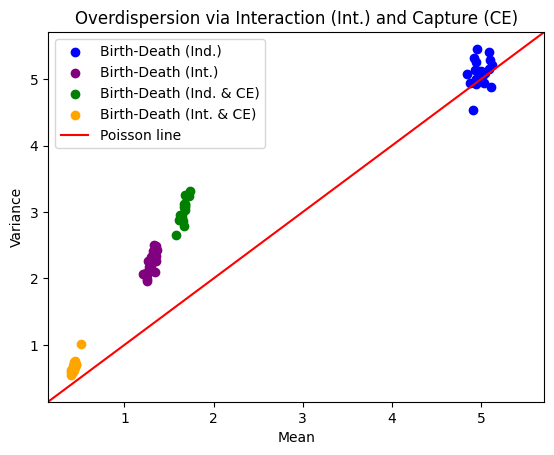

In [73]:
L = np.inf
U = 0
L, U = custom_scatter(data_BD_ind, L, U, "blue", "Birth-Death (Ind.)")
L, U = custom_scatter(data_BD_int, L, U, "purple", "Birth-Death (Int.)")
L, U = custom_scatter(data_BD_D_ind, L, U, "green", "Birth-Death (Ind. & CE)")
L, U = custom_scatter(data_BD_D_int, L, U, "orange", "Birth-Death (Int. & CE)")
#L, U = custom_scatter(data_TE_ind, L, U, "green", "Telegraph (Independent)")
#L, U = custom_scatter(data_TE_int, L, U, "orange", "Telegraph (Interacting)")
plt.xlabel("Mean")
plt.ylabel("Variance")
plt.title("Overdispersion via Interaction (Int.) and Capture (CE)")
plt.axline([L, L], [U, U], color="red", label="Poisson line")
plt.legend()

# Misc code

In [ ]:
for intr_plot in interaction_values:

    samples = []
    k = 0
    for intr in interaction_values:
        for gene in gene_values:

            if intr != intr_plot:
                k += 1
                continue

            sample = data.count_dataset.iloc[k]
            x1_sample = [x[0] for x in sample]
            samples.append(x1_sample)

            k += 1

    fig, axs = plt.subplots(figsize=(12, 6))
    vp = axs.violinplot(
        samples,
        showextrema=False
    )
    colours = ["red", "blue", "green", "orange"]
    for i, vi in enumerate(vp['bodies']):
        vi.set_facecolor(colours[i])
        vi.set_edgecolor(None)
        vi.set_alpha(1)
    labels = [str(gene) for gene in gene_values]
    axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    axs.set_xlim(0.25, len(labels) + 0.75)
    axs.set_xlabel(r'Gene parameter $k_{on}$')
    axs.set_ylabel("Counts")
    axs.set_title(r"Stationary Distributions: $k_{reg} =$" + f"{intr_plot}")

In [ ]:
for gene_plot in gene_values:

    samples = []
    k = 0
    for intr in interaction_values:
        for gene in gene_values:

            if gene != gene_plot:
                k += 1
                continue

            sample = data.count_dataset.iloc[k]
            x1_sample = [x[0] for x in sample]
            samples.append(x1_sample)

            k += 1

    fig, axs = plt.subplots(figsize=(12, 6))
    vp = axs.violinplot(
        samples,
        showextrema=False
    )
    colours = ["red", "blue", "green", "orange"]
    for i, vi in enumerate(vp['bodies']):
        vi.set_facecolor(colours[i])
        vi.set_edgecolor(None)
        vi.set_alpha(1)
    labels = [str(intr) for intr in interaction_values]
    axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    axs.set_xlim(0.25, len(labels) + 0.75)
    axs.set_xlabel(r'Interaction parameter $k_{reg}$')
    axs.set_ylabel("Counts")
    axs.set_title(r"Stationary Distributions: $k_{on} =$" + f"{gene_plot}")